In [1]:
# numpy and pandas for data manipulation
import numpy as np
import pandas as pd 

# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder

# File system manangement
import os
import gc

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split

In [15]:
pd.options.display.max_columns = None
pd.options.display.max_rows = None

# Data Preparation

In [2]:
# load train and test data
df_train = pd.read_csv('input/application_train.csv')
df_test = pd.read_csv('input/application_test.csv')

df = pd.concat([df_train, df_test], ignore_index=True)

# Rename columns to lower case
df.rename(columns=str.lower, inplace=True)
df_train.rename(columns=str.lower, inplace=True)
df_test.rename(columns=str.lower, inplace=True)

In [ ]:
# code_gender: drop 'XNA' lines of code_gender
df = df[df['code_gender'] != 'XNA']

# name_type_suite: fillna as 'Other_C'
df.name_type_suite.fillna('Other_C', inplace=True)

# occupation_type fillna
df.occupation_type.fillna('Unknown', inplace=True)
df_train.occupation_type.fillna('Unknown', inplace=True)

# name_family_status: remove "Unknown"
df = df[df.name_family_status != 'Unknown']

# fondkapremont_mode
# housetype_mode
# wallsmaterial_mode
# emergencystate_mode
df.fondkapremont_mode.fillna('Unknown',inplace=True)
df.wallsmaterial_mode.fillna('Unknown',inplace=True)
df.housetype_mode.fillna('Unknown',inplace=True)
df.emergencystate_mode.fillna('Unknown',inplace=True)

# days_employed: replace 365243
df['days_employed'].replace(365243, np.nan, inplace= True)


# Convert occupation_type 
#  and organization_type 
#  to numeric values

# default percent by occupation_type
tf_occu = df_train.groupby('occupation_type')['target'].agg(['sum','count'])
tf_occu['percent'] = tf_occu['sum']/tf_occu['count']

# default percent by organization_type
tf_org = df_train.groupby('organization_type')['target'].agg(['sum','count'])
tf_org['percent'] = tf_org['sum']/tf_org['count']

def job_score(row):
    return tf_occu.loc[row['occupation_type']]['percent'] + tf_org.loc[row['organization_type']]['percent']

df['job_score'] = df.apply(job_score, axis = 1)

del tf_occu, tf_org
gc.collect()
df.drop(['occupation_type', 'organization_type'], axis=1, inplace=True)

# Convert binary cat to int
for feature in ['name_contract_type', 'code_gender', 'flag_own_car', 'flag_own_realty']:
    df[feature], uniques = pd.factorize(df[feature])
    
# Some simple features
df['days_employed_perc'] = df['days_employed'] / df['days_birth']
df['income_credit_perc'] = df['amt_income_total'] / df['amt_credit']
df['income_per_person'] = df['amt_income_total'] / df['cnt_fam_members']
df['annuity_income_perc'] = df['amt_annuity'] / df['amt_income_total']
df['payment_rate'] = df['amt_annuity'] / df['amt_credit']

flag_doc = [c for c in df.columns if ('flag_docu' in c)]
df['doc_total'] = df[flag_doc].apply(sum, axis=1)

del df_train, df_test
gc.collect()

# convert to categorical features
categorical = list(df.select_dtypes(include=['object']).columns)

for feature in categorical:
    df[feature], uniques = pd.factorize(df[feature])

# Training LightGBM model

In [35]:
# LightGBM GBDT with KFold or Stratified KFold
# Parameters from Tilii kernel: https://www.kaggle.com/tilii7/olivier-lightgbm-parameters-by-bayesian-opt/code
def kfold_lightgbm(df, num_folds, stratified = False, debug= False):
    # Divide in training/validation and test data
    train_df = df[df['target'].notnull()]
    test_df = df[df['target'].isnull()]
    print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
    del df
    gc.collect()
    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=1001)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=1001)
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in ['target','sk_id_curr','sk_id_bureau','sk_id_prev','index']]
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['target'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['target'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['target'].iloc[valid_idx]

        # LightGBM parameters found by Bayesian optimization
        clf = LGBMClassifier(
            nthread=4,
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            categorical_features=categorical,
            silent=-1,
            verbose=-1, )

        clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
            eval_metric= 'auc', verbose= 100, early_stopping_rounds= 200)

        oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
        sub_preds += clf.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
        del clf, train_x, train_y, valid_x, valid_y
        gc.collect()

    print('Full AUC score %.6f' % roc_auc_score(train_df['target'], oof_preds))
    # Write submission file and plot feature importance
    if not debug:
        test_df['target'] = sub_preds
        test_df[['sk_id_curr', 'target']].to_csv(submission_file_name, index= False)
    return feature_importance_df

In [36]:
feat_importance = kfold_lightgbm(df, num_folds= 5, stratified=True, debug= True)

Starting LightGBM. Train shape: (307511, 123), test shape: (48744, 123)
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.753823	valid_1's auc: 0.746515
[200]	training's auc: 0.770246	valid_1's auc: 0.756808
[300]	training's auc: 0.780029	valid_1's auc: 0.760666
[400]	training's auc: 0.787741	valid_1's auc: 0.762575
[500]	training's auc: 0.794322	valid_1's auc: 0.76334
[600]	training's auc: 0.800243	valid_1's auc: 0.763859
[700]	training's auc: 0.805512	valid_1's auc: 0.763801
[800]	training's auc: 0.810456	valid_1's auc: 0.763767
Early stopping, best iteration is:
[613]	training's auc: 0.800973	valid_1's auc: 0.763914
Fold  1 AUC : 0.763914
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.753901	valid_1's auc: 0.744738
[200]	training's auc: 0.770639	valid_1's auc: 0.755686
[300]	training's auc: 0.780258	valid_1's auc: 0.759256
[400]	training's auc: 0.78767	valid_1's auc: 0.761078
[500]	training's auc: 0.793975	

# Feature importance plot

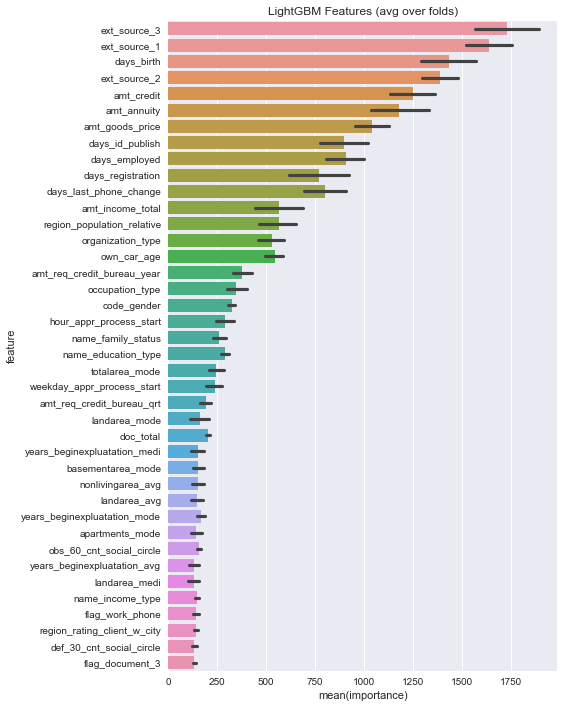

In [43]:
feature_importance_df_ = feat_importance
cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
plt.figure(figsize=(8, 10))
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()